# *(Fazli and Richard, 2022)*: Electrically Coupled Bursting Pituitary Cells

Implementation of the paper:

- Fazli, Mehran, and Richard Bertram. "Network Properties of Electrically
  Coupled Bursting Pituitary Cells." Frontiers in Endocrinology 13 (2022).

In [1]:
import brainpy as bp
import brainpy.math as bm

In [2]:
class PituitaryCell(bp.NeuGroup):
  def __init__(self, size, name=None):
    super(PituitaryCell, self).__init__(size, name=name)

    # parameter values
    self.vn = -5
    self.kc = 0.12
    self.ff = 0.005
    self.vca = 60
    self.vk = -75
    self.vl = -50.0
    self.gk = 2.5
    self.cm = 5
    self.gbk = 1
    self.gca = 2.1
    self.gsk = 2
    self.vm = -20
    self.vb = -5
    self.sn = 10
    self.sm = 12
    self.sbk = 2
    self.taun = 30
    self.taubk = 5
    self.ks = 0.4
    self.alpha = 0.0015
    self.gl = 0.2

    # variables
    self.V = bm.Variable(bm.random.random(self.num) * -90 + 20)
    self.n = bm.Variable(bm.random.random(self.num) / 2)
    self.b = bm.Variable(bm.random.random(self.num) / 2)
    self.c = bm.Variable(bm.random.random(self.num))
    self.input = bm.Variable(self.num)

    # integrators
    self.integral = bp.odeint(bp.JointEq(self.dV, self.dn, self.dc, self.db), method='exp_euler')

  def dn(self, n, t, V):
    ninf = 1 / (1 + bm.exp((self.vn - V) / self.sn))
    return (ninf - n) / self.taun

  def db(self, b, t, V):
    bkinf = 1 / (1 + bm.exp((self.vb - V) / self.sbk))
    return (bkinf - b) / self.taubk

  def dc(self, c, t, V):
    minf = 1 / (1 + bm.exp((self.vm - V) / self.sm))
    ica = self.gca * minf * (V - self.vca)
    return -self.ff * (self.alpha * ica + self.kc * c)

  def dV(self, V, t, n, b, c):
    minf = 1 / (1 + bm.exp((self.vm - V) / self.sm))
    cinf = c ** 2 / (c ** 2 + self.ks * self.ks)
    ica = self.gca * minf * (V - self.vca)
    isk = self.gsk * cinf * (V - self.vk)
    ibk = self.gbk * b * (V - self.vk)
    ikdr = self.gk * n * (V - self.vk)
    il = self.gl * (V - self.vl)
    return -(ica + isk + ibk + ikdr + il + self.input) / self.cm

  def update(self, tdi, x=None):
    V, n, c, b = self.integral(self.V.value, self.n.value, self.c.value, self.b.value, tdi.t, tdi.dt)
    self.V.value = V
    self.n.value = n
    self.c.value = c
    self.b.value = b

  def clear_input(self):
    self.input.value = bm.zeros_like(self.input)

In [3]:
class PituitaryNetwork(bp.Network):
  def __init__(self, num, gc):
    super(PituitaryNetwork, self).__init__()

    self.N = PituitaryCell(num)
    self.gj = bp.synapses.GapJunction(self.N, self.N, bp.conn.All2All(include_self=False), g_max=gc)

  0%|          | 0/20000 [00:00<?, ?it/s]

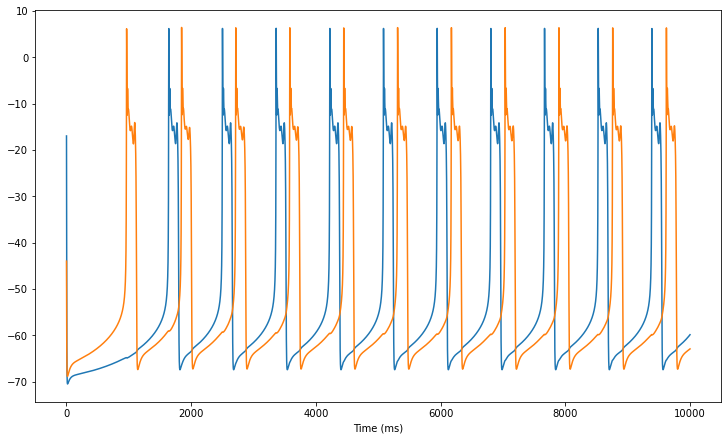

In [4]:
net = PituitaryNetwork(2, 0.002)
runner = bp.DSRunner(net, monitors={'V': net.N.V}, dt=0.5)
runner.run(10 * 1e3)

fig, gs = bp.visualize.get_figure(1, 1, 6, 10)
fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(runner.mon.ts, runner.mon.V, plot_ids=(0, 1), show=True)